In [481]:
import functools
import itertools

import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Latex
from tqdm import tqdm, trange

from rpy2.robjects import r, pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter

def pandas_py2r(df, name):
    '''Записывает датафрейм df из среды Питона в среду R в переменную name'''
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_from_pd_df = ro.conversion.py2rpy(df)
    ro.globalenv[name] = r_from_pd_df
    
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
df = pd.read_csv('IB_statistics_data_hw2.3.txt', sep=' ')
df.head()

,Ex1a.y,Ex1a.x1,Ex1a.x2,Ex1a.x3,Ex1b.y,Ex1b.x1,Ex1b.x2,Ex1b.x3,Ex2.y,Ex2.x1,...,Ex5.x2,Ex5.x3,Ex5.x4,Ex5.x5,Ex5.x6,Ex5.x7,Ex5.x8,Ex5.x9,Ex5.x10,Ex5.x11
0,8.399957,-0.578567,-0.231104,1.606654,5.816002,-0.406706,1.419268,1.715658,6.161514,7.938226,...,96.966764,2.079442,-0.087605,2.014537,-3.462460,2.418999,0.567154,2,4,0.854740
1,1.634655,-0.778309,0.297055,-1.468423,-4.858844,-0.741628,0.034264,-2.740382,-5.565632,3.859199,...,103.965235,2.564949,-2.934512,3.410054,3.898134,2.171806,0.503318,0,2,-2.755416
2,0.947989,-0.684660,-0.278228,-0.938922,11.166682,0.840191,-1.191674,1.620678,4.135642,7.101848,...,100.866511,2.484907,-0.398981,2.540265,0.456881,1.013894,0.227123,3,2,-0.930360
3,1.619562,-0.002725,-2.049381,0.061738,-1.095769,-0.536900,0.737190,-0.984292,-11.639614,1.497553,...,101.483493,2.484907,0.049122,3.255772,1.426734,1.433352,0.323969,3,2,-0.101315
4,-0.834499,1.868469,0.308913,-1.103748,4.644099,-0.362526,1.064327,1.275186,-17.554264,2.572835,...,99.922260,2.995732,-2.038997,3.681475,-0.390280,0.687196,0.153218,1,5,2.890657


# 1.
## a)

Поскольку ковариационная матрица не вырождена, то можно воспользоваться обобщённым МНК:
$$
\hat \beta = (\mathbb X^T V_n^{-1} \mathbb X) ^ {-1} \mathbb X^T V_n^{-1} \mathbb Y = 
B^{-1}\mathbb X^T V_n^{-1} \mathbb Y
$$

In [4]:
X, Y = df.loc[:, 'Ex1a.x1':'Ex1a.x3'], df['Ex1a.y']
X.columns = ['x1', 'x2', 'x3']
n, m = X.shape

X.insert(0, 'x0', 1)

display(Latex('$V_n = $'))
V = np.eye(n) + np.ones(shape=(n, n))
V

<IPython.core.display.Latex object>

array([[2., 1., 1., ..., 1., 1., 1.],
       [1., 2., 1., ..., 1., 1., 1.],
       [1., 1., 2., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 2., 1., 1.],
       [1., 1., 1., ..., 1., 2., 1.],
       [1., 1., 1., ..., 1., 1., 2.]])

In [5]:
V_inv = np.linalg.inv(V)

B = X.transpose() @ V_inv @ X
B_inv = np.linalg.inv(B)

beta = B_inv @ X.transpose() @ V_inv @ Y
display(Latex(r'$\hat \beta =$'))
beta

<IPython.core.display.Latex object>

0    4.796692
1   -0.999798
2    2.029286
3    2.986783
dtype: float64

## b)

In [6]:
X, Y = df.loc[:, 'Ex1b.x1':'Ex1b.x3'], df['Ex1b.y']
X.columns = ['x1', 'x2', 'x3']
n, m = X.shape

X.insert(0, 'x0', 1)

V = np.eye(n) + np.ones(shape=(n, n))
V[-1, :] = V[:, -1] = 2
V[-1, -2] = V[-2, -1] = 4
V[-1, -1] = 8
display(Latex(r'$V_n=$'))
V

<IPython.core.display.Latex object>

array([[2., 1., 1., ..., 1., 1., 2.],
       [1., 2., 1., ..., 1., 1., 2.],
       [1., 1., 2., ..., 1., 1., 2.],
       ...,
       [1., 1., 1., ..., 2., 1., 2.],
       [1., 1., 1., ..., 1., 2., 4.],
       [2., 2., 2., ..., 2., 4., 8.]])

### Вариант 1
Использовать псевдообратную матрицу:

In [7]:
V_pinv = np.linalg.pinv(V)

B = X.transpose() @ V_pinv @ X
B_inv = np.linalg.inv(B)

beta = B_inv @ X.transpose() @ V_pinv @ Y
display(Latex(r'$\hat \beta =$'))
beta

<IPython.core.display.Latex object>

0    3.661509
1    0.944773
2   -1.872425
3    3.034140
dtype: float64

### Вариант 2
Всего есть 230 наблюдений, и вклад одного конкретного наблюдения в модель будет незначителен.

Ошибки в последнем наблюдении "плохие", можно его выбросить - тогда у матрицы ковариации ошибок будет существовать обратная матрица, и мы снова сможем воспользоваться обобщённым МНК.


In [8]:
X2 = X.iloc[:-1, :]
Y2 = Y[:-1]
V2 = V[:-1, :-1]
display(Latex(r"$V_{n2} = $"))
V2

<IPython.core.display.Latex object>

array([[2., 1., 1., ..., 1., 1., 1.],
       [1., 2., 1., ..., 1., 1., 1.],
       [1., 1., 2., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 2., 1., 1.],
       [1., 1., 1., ..., 1., 2., 1.],
       [1., 1., 1., ..., 1., 1., 2.]])

In [9]:
V2_inv = np.linalg.inv(V2)

B2 = X2.transpose() @ V2_inv @ X2
B2_inv = np.linalg.inv(B2)

beta = B2_inv @ X2.transpose() @ V2_inv @ Y2
display(Latex(r'$\hat \beta =$'))
beta

<IPython.core.display.Latex object>

0    3.561558
1    0.944417
2   -1.874056
3    3.034178
dtype: float64

*P.S*. Я бы выбрал второй вариант.

# 2.

In [711]:
X = df.loc[:, 'Ex2.x1':'Ex2.x4']
X.columns = ['x1', 'x2', 'x3', 'x4']
n, m = X.shape

X.insert(0, 'x0', 1)

Y = df['Ex2.y']

Для сравнения моделей будем использовать $R^2_{adj}$.

In [709]:
def R2adj(Y_pred, Y_true, n, m):
    # n - число наблюдений
    # m - число независимых переменных
    num = np.sum((Y_true - Y_pred)**2)
    denum = np.sum((Y_true - Y_true.mean())**2)
    
    return 1 - num / denum * (n - 1) / (n - m)

### 1)
Ковариационная матрица ошибок имеет вид $\sigma^2 \mathbb 1$

In [712]:
# Обычный МНК
beta = np.linalg.lstsq(X, Y, rcond=None)[0]   

s2 = (Y - X @ beta).transpose() @ (Y - X @ beta) / (n - m)
display(Latex(fr'$\hat \beta = $'))
print(*[round(b, 3) for b in beta], sep='\n')
display(Latex(fr'$s^2 = {round(s2, 3)}$'))

<IPython.core.display.Latex object>

0.211
1.022
0.981
-0.013
-0.3


<IPython.core.display.Latex object>

In [713]:
R_1 = R2adj(Y, X @ beta, n, m)
R_1

0.9999906937211583

### 2)
* Матрица ковариаций ошибок имеет вид:
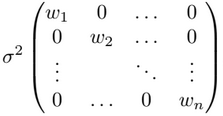
где $\omega_i = 1 + \frac{i}{n}$.

Оценим парамер $\sigma^2$. Для этого обычным МНК получим оценку $\hat \beta$ и составим вектор, $i$-я координата которого равна $Res_i^2 = \left(y_i - (\hat \beta, x_i)\right)^2$ и является оценкой для
$\sigma^2 \omega_i$.

Найдём оценку для $\sigma^2$:
$$
s^2 = \text{argmin} \sum_i (\sigma^2 \omega_i - Res_i^2)^2
$$

In [714]:
Res2 = (Y - X @ beta )**2  # вектор квадратов остатков
omega = np.array([1 + i / n for i in range(1, n + 1)])

s2 = sp.optimize.minimize(lambda sigma2: np.sum(((sigma2 * omega) - Res2))**2, Res.mean()).x[0]
display(Latex(rf'$s^2 = {round(s2, 3)}$'))

<IPython.core.display.Latex object>

Тогда оценка матрици ковариации будет иметь вид:

In [715]:
Vn = s2 * np.diag([1 + i / n  for i in range(1, n + 1)])
display(Latex(r"$V_n = $"))
np.around(Vn, 3)

<IPython.core.display.Latex object>

array([[0.885, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.889, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.893, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 1.755, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 1.758, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 1.762]])

Теперь, когда есть оценка матрицы ковариации, можно применить обобщённый (взвешенный) МНК:

In [716]:
Vn_inv = np.linalg.inv(Vn)
B = X.transpose() @ Vn_inv @ X
B_inv = np.linalg.inv(B)

beta_wls = np.array(B_inv @ X.transpose() @ Vn_inv @ Y)
display(Latex(r'$\hat \beta_{WLS} = $'))
print(*[round(b, 3) for b in beta_wls], sep='\n')

<IPython.core.display.Latex object>

0.222
1.009
0.984
-0.013
-0.3


In [717]:
R_2 = R2adj(Y, X @ beta_wls, n, m)
R_2

0.9999906802360838

Посмотрим по-внимательнее на зависимость между 𝑥4 и 𝑦:

Коэффициент корреляции:  -0.9999105747621628


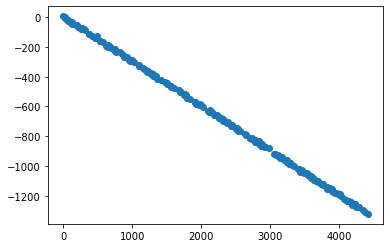

In [718]:
print('Коэффициент корреляции: ', sp.stats.pearsonr(X.x4, Y)[0])
plt.scatter(X.x4, Y);

### 3)

Дисперсии в первых $\frac{n}{3}$ наблюдегиях равны $\omega_1$, в следующей трети они равны $\omega_2$, в оставшихся наблюдениях - $\omega_3$.

In [719]:
# обычный МНК
beta = np.linalg.lstsq(X, Y, rcond=None)[0]

# оценка вектора ошибок
epsilon = X @ beta - Y  

# разбиение вектора ошибок на 3 подвектора
n1 = n // 3
n2 = 2 * n1

epsilon1 = epsilon[:n1]
epsilon2 = epsilon[n1:n2]
epsilon3 = epsilon[n2:]

# оценки omega_i
omega1 = epsilon1 @ epsilon1 / n1
omega2 = epsilon2 @ epsilon2 / (n2 - n1)
omega3 = epsilon3 @ epsilon3 / (n - n2)

for i, omega in enumerate((omega1, omega2, omega3)):
    display(Latex(rf'$\omega_{i+1}^2 = {round(omega, 3)}$'))

# делим переменные на соотв. веса
X3, Y3 = X.copy(), Y.copy()

X3[:n1] = X3[:n1] / omega1
X3[n1:n2] = X3[n1:n2] / omega2
X3[n2:] = X3[n2:] / omega3

Y3[:n1] = Y3[:n1] / omega1
Y3[n1:n2] = Y3[n1:n2] / omega2
Y3[n2:] = Y3[n2:] / omega3

# обычная регрессия для преобразованной модели
beta3 = np.linalg.lstsq(X3, Y3, rcond=None)[0]

display(Latex(r'$\hat \beta = $'))
print(*[round(b, 3) for b in beta], sep='\n')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

0.211
1.022
0.981
-0.013
-0.3


In [720]:
R_3 = R2adj(Y3, X3 @ beta3, n, m)
R_3

0.9999865534046

### 4)
Дисперсия ошибки пропорциональная третьему признаку ($\sigma^2 \cdot x_3$).

In [721]:
# делим уравнения на x3
Y4 = Y.copy() / X.x3

X4 = X.copy() 
for column in X4.columns:
    X4[column] = X4[column] / X.x3

# обычная регрессия для преобразованной модели
beta4 = np.linalg.lstsq(X4, Y4, rcond=None)[0]
s2_4 = (Y4 - X4 @ beta4).transpose() @ (Y4 - X4 @ beta4) / (n - m)
display(Latex(r'$\hat \beta_4 = $'))
print(*[round(b, 3) for b in beta4], sep='\n')
display(Latex(rf'$s^2 = {round(s2_4, 3)}$'))

<IPython.core.display.Latex object>

-0.435
1.012
1.046
0.083
-0.3


<IPython.core.display.Latex object>

In [722]:
R_4 = R2adj(Y4, X4 @ beta4, n, m)
R_4

0.9999676244211001

### Выбор модели

In [723]:
display(X.describe())
display(Latex(r'$R^2_{adj}$ scores:'))
print(*(R_1, R_2, R_3, R_4), sep='\n')

,x0,x1,x2,x3,x4
count,230.0,230.000000,230.000000,230.000000,230.000000
mean,1.0,2.121755,1.278261,9.620725,2356.213441
std,0.0,2.961267,4.220035,6.657446,1268.926395
min,1.0,-6.336296,-3.000000,0.293934,-0.006809
25%,1.0,0.107000,-3.000000,4.721898,1272.054938
50%,1.0,2.083834,1.000000,6.613538,2473.079359
75%,1.0,4.381214,5.000000,14.371775,3483.703292
max,1.0,8.268442,13.000000,24.783255,4412.123276


<IPython.core.display.Latex object>

0.9999906937211583
0.9999906802360838
0.9999865534046
0.9999676244211001



Предиктор $x_4$ имеет гораздо бОльшую дисперсию, чем остальные, и его коэффициент корреляции с зависимой переменной близок к 1, поэтому все модели имеют одинаково хорошее значение $R^2_{adj}$. 

Наивысшее значение имеет 1-ая модель, поэтому можно выбрать её. Однако имеет смысл строить модель с единственным предиктором $x_4$.

# 3.

In [74]:
X = df.loc[:, 'Ex4.x1':'Ex4.x4']
X.columns = ['x1', 'x2', 'x3', 'x4']
n, m = X.shape
X.insert(0, 'x0', 1)

Y = df['Ex4.y']


### a) Проверка гипотезы о наличии автокорреляции

Таблица критических значений статистики Дарбина-Уотсона для уровня значимости 0.05:

https://www.real-statistics.com/statistics-tables/durbin-watson-table/

Возьмём значения для $n = 250$, $k = 4$ (тогда критерий получится радикальным):

$d_l = 1.676, \ \ d_u = 1.740$

In [117]:
dl, du = 1.676, 1.740

beta = np.linalg.lstsq(X, Y, rcond=None)[0] 

# оценка вектора ошибок
epsilon = X @ beta - Y

# вычисление статистики
num = np.sum([(epsilon[i] - epsilon[i-1])**2 for i in range(1, n)])
denum = epsilon @ epsilon
D = num / denum

display(Latex(fr'$D = {round(D, 3)}$'))

<IPython.core.display.Latex object>

In [118]:
du < D < 4 - du

True

$\Rightarrow H_0: r = 0$ принимается.

На всякий случай проверим в R, где $p$-значение моделируется с помощью bootstrap-a:

In [119]:
tmp = X.copy()
tmp['y'] = Y.copy()

pandas_py2r(tmp, 'df')  # копирование в среду R
del tmp

In [120]:
%%R
res = car::durbinWatsonTest(lm('y ~ 0 + x0 + x1 + x2 + x3 + x4', data=df), simulate=TRUE, reps=1000)
res

 lag Autocorrelation D-W Statistic p-value
   1      0.06922951      1.852996   0.246
 Alternative hypothesis: rho != 0


$p$-значение $> 0.05 \Rightarrow H_0$ принимается (точно).

### b) Гипотеза об отсутствии корреляции принялась.

### с) Моделирование распределения статистики критерия Дарбина-Уотсона в случае отсутствия авктокорреляции

$m = 6, n = 111$

In [212]:
np.random.seed(28)

n, m = 111, 6

# (m + 1) - мерное нормальное распределение с единичной ковариационной матрицей
# вектор средних равен (0, 1, ... m)
distr = sp.stats.multivariate_normal(np.arange(m + 1), cov=1)

N = 100000  # число итераций
D_values = np.zeros(N)

for i in trange(N):
    
    sample = distr.rvs(size=n)

    X = np.ones(shape=(n, m+1))
    X[:, 1:] = sample[:, 1:]
    Y = sample[:, 0]

    beta = np.linalg.lstsq(X, Y, rcond=None)[0]

    epsilon = X @ beta - Y

    num = np.sum((epsilon[1:] - epsilon[:-1])**2)
    denum = epsilon @ epsilon

    D_values[i] = num / denum

100%|██████████| 100000/100000 [00:38<00:00, 2616.69it/s]


Построение графика:

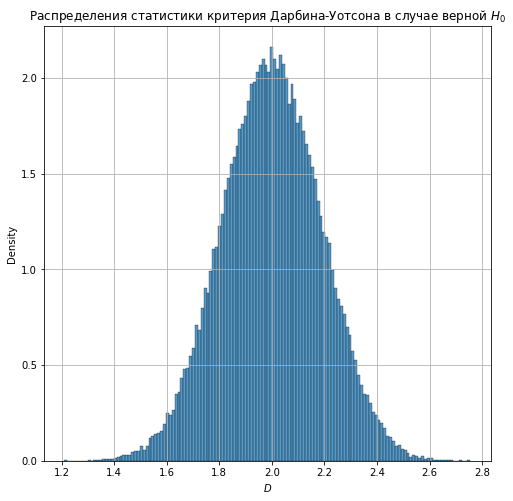

In [229]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(D_values, stat='density', ax=ax)
ax.grid()
ax.set_xlabel('$D$');
ax.set_title('Распределения статистики критерия Дарбина-Уотсона в случае верной $H_0$');

# 4.

In [468]:
X = df.loc[:, 'Ex4.x1':'Ex4.x4']
X.columns = ['x1', 'x2', 'x3', 'x4']
n, m = X.shape
X.insert(0, 'x0', 1)
X = np.array(X)

Y = np.array(df['Ex4.y'])

In [469]:
def var(r, sigma2, beta):
    # среднеквадратичное отклонение ридж-оценки
    B = np.linalg.matrix_power(X.transpose() @ X + r * np.eye(m+1), -2)
    
    return r**2 * beta.transpose() @ B @ beta_ols + sigma2 * np.trace(X @ B @ X.transpose())

def beta_ridge(r):
    # ридж-оценка как функция гребня
    return np.linalg.inv(X.transpose() @ X + r * identity) @ X.transpose() @ Y

Итеративный алгоритм:

In [470]:
np.random.seed(28)

r = 0

# вычисление оценки sigma^2
beta = np.linalg.lstsq(X, Y, rcond=None)[0]
sigma2 = (X @ beta - Y).transpose() @ (X @ beta - Y) / (n - m)

display(Latex(rf'$\hat \sigma^2 = {round(sigma2, 3)}$'))
display(Latex(r'$\hat \beta_{OLS} = $'))
print(*[round(b, 3) for b in beta], sep='\n')

beta_r = beta_ridge(0.0)
prev = -beta_r.copy()  # предыдущее значение 

eps = 1e-7

i = 0  # счётчик итераций
while np.sum((beta_r - prev)**2) > eps:
    
    i += 1
    prev = beta_r.copy()
    
    # новое значение гребня из минимизации СКО
    res = sp.optimize.minimize(lambda r: var(r, sigma2, beta_r), res.x)
    
    # перерасчёт ridge-оценки
    beta_r = beta_ridge(res.x[0])

display(Latex(r'$\hat \beta_{RIDGE} = $'))
print(*[round(b, 3) for b in beta_r], sep='\n')
print(f'Число итераций: {i}')
print(f'Оптимальное значение гребня: {round(res.x[0], 3)}')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

543.219
-156.619
-468.599
-231.471
178.892


<IPython.core.display.Latex object>

0.837
1.946
-0.09
2.791
2.682
Число итераций: 3
Оптимальное значение гребня: 2.906


# 5.

In [704]:
X = df.loc[:, 'Ex5.x1':'Ex5.x11']
X.columns = [f'x{i}' for i in range(1, 12)]
X.insert(0, 'x0', 1)
X = np.array(X)

Y = np.array(df['Ex5.y'])

В качестве метрики будет использоваться $R^2_{adj}$:

In [708]:
def R2adj(Y_pred, Y_true, n, m):
    # n - число наблюдений
    # m - число независимых переменных
    num = np.sum((Y_true - Y_pred)**2)
    denum = np.sum((Y_true - Y_true.mean())**2)
    
    return 1 - num / denum * (n - 1) / (n - m)

In [706]:
def model_selection(X, Y, metric, method='all', printall=False):
    if method == 'all':
        return _select_all(X, Y, metric, printall)
        
    elif method == 'forward':
        return _select_forward(X, Y, metric)
        
    elif method == 'backward':
        return _select_backward(X, Y, metric)
    

def _select_all(X, Y, metric, printall=False):
    
    def generate_binary_strings(cases, n, s, i):  
        """
        Генерирует n^2 бинарных строк, заполняя ими список cases.
        '1' на i-ой позиции в строке соотвествует тому, что этот предиктор добавляется в модель;
        '0' - не добавляется.
        """
        if i == n: 
            cases.append(s)
            return

        generate_binary_strings(cases, n, s + '0', i + 1)  
        generate_binary_strings(cases, n, s + '1', i + 1)
    
    n = X.shape[0]
    m = X.shape[1] - 1  # intercept не считаем
    
    cases = []
    generate_binary_strings(cases, m, "", 0)
    
    best_score = -np.inf
    best_model = []
    
    for case in cases:
        
        indexes = [0]  # всегда берём intercept
        for index, flag in enumerate(case):
            if flag == '1':
                indexes.append(index + 1)
        
        X_case = X[:, indexes]
        beta_case = np.linalg.lstsq(X_case, Y, rcond=None)[0]
        
        m_case = X_case.shape[1] - 1
        score = metric(X_case @ beta_case, Y, n, m_case)
        
        if printall:
            print(indexes, score)
        
        if score > best_score:
            best_score = score
            best_model = indexes
       
    return best_model, best_score


def _select_backward(X, Y, metric):
    
    def step(X, Y, flags, metric, current_best_score):
        
        # х-ки лучшей из моделей, полученных удалением предиктора
        best_score = -np.inf 
        best_model_removed_predictor_index = None  
        
        for index, flag in enumerate(flags):
            if index and flag:  # если этот предиктор ещё не отбросили; (intercept не отбрасываем)
                
                case = flags.copy()
                case[index] = 0
                
                indexes = [i for i, x in enumerate(case) if x]  # генерируем индексы новой модели
                
                X_case = X[:, indexes]
                m_case = X_case.shape[1] - 1
                beta_case = np.linalg.lstsq(X_case, Y, rcond=None)[0]
                
                score = metric(X_case @ beta_case, Y, n, m_case)
                
                if score > best_score:
                    best_score = score
                    best_model_removed_predictor_index = index
                
        if best_score > current_best_score:
            flags[best_model_removed_predictor_index] = 0
            return step(X, Y, flags, metric, best_score)
        else:
            indexes = [i for i, flag in enumerate(flags) if flag]
            return indexes, current_best_score
        
    flags = [1] * X.shape[1]
    best_score = -np.inf
    
    return step(X, Y, flags, metric, best_score)
        
    
def _select_forward(X, Y, metric):
    
    def step(X, Y, flags, metric, current_best_score):
        
        # х-ки лучшей из моделей, полученных добавлением предиктора
        best_score = -np.inf 
        best_model_added_predictor_index = None  
        
        for index, flag in enumerate(flags):
            if not flag:  # если этот предиктор ещё не добавили
                
                case = flags.copy()
                case[index] = 1  # помечаем предиктор на добавление
                
                indexes = [i for i, x in enumerate(case) if x]  # генерируем индексы новой модели
                
                X_case = X[:, indexes]
                m_case = X_case.shape[1] - 1
                beta_case = np.linalg.lstsq(X_case, Y, rcond=None)[0]
                
                score = metric(X_case @ beta_case, Y, n, m_case)
                
                if score > best_score:
                    best_score = score
                    best_model_added_predictor_index = index
                
        if best_score > current_best_score:
            flags[best_model_added_predictor_index] = 1
            return step(X, Y, flags, metric, best_score)
        else:
            indexes =  [i for i, flag in enumerate(flags) if flag]
            return indexes, current_best_score
        
    flags = [0] * X.shape[1]
    flags[0] = 1 # сразу добавим intercept
    best_score = -np.inf
    
    return step(X, Y, flags, metric, best_score)

In [707]:
for method in ('forward', 'backward', 'all'):
    indexes, score = model_selection(X, Y, R2adj, method=method)
    predictors = [f'x{i}' for i in indexes]
    print('=' * 20)
    print(f'Метод отбора: {method}')
    display(Latex(r'$R^2_{adj} = ' + str(round(score, 3)) + '$'))
    print(f"Предикторы: {', '.join(predictors)}")

Метод отбора: forward


<IPython.core.display.Latex object>

Предикторы: x0, x1, x2, x4, x7, x9, x10
Метод отбора: backward


<IPython.core.display.Latex object>

Предикторы: x0, x1, x2, x4, x7, x9, x10
Метод отбора: all


<IPython.core.display.Latex object>

Предикторы: x0, x1, x2, x4, x7, x9, x10


### Проверка средствами R

In [684]:
tmp = pd.DataFrame(X)
tmp.columns = [f'x{i}' for i in range(12)]
tmp['y'] = Y.copy()

pandas_py2r(tmp, 'df')
del tmp


#### Регрессия всех подмножеств

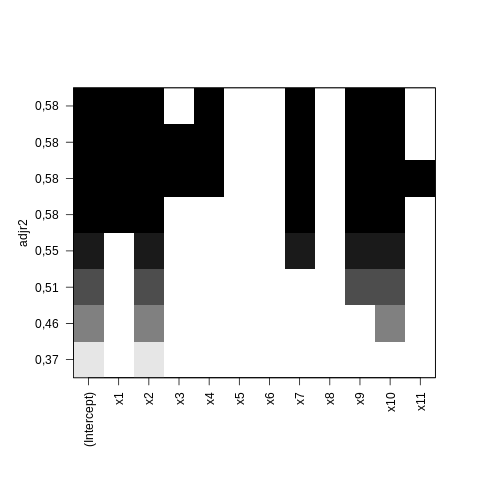

In [682]:
%%R
library(leaps)

res = regsubsets(y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11, data=df,
                method='exhaustive')
plot(res, scale='adjr2')

#### Прямой отбор

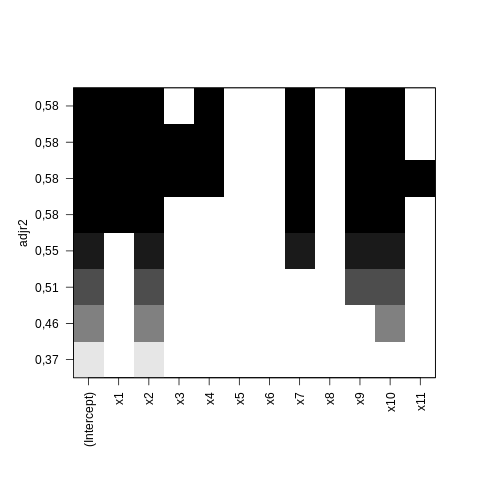

In [683]:
%%R
res = regsubsets(y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11, data=df,
                method='forward')
plot(res, scale='adjr2')

#### Обратный отбор

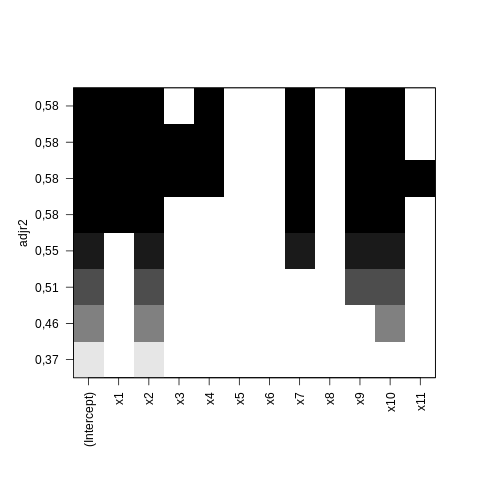

In [685]:
%%R
res = regsubsets(y ~ x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11, data=df,
                method='backward')
plot(res, scale='adjr2')

Вроде бы сходится.